In [6]:
!mkdir /aiffel/.kaggle
!mv /aiffel/kaggle.json /aiffel/.kaggle

mkdir: cannot create directory ‘/aiffel/.kaggle’: File exists


In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100%|██████████████████████████████████████▊| 2.28G/2.29G [00:18<00:00, 147MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:18<00:00, 134MB/s]


In [5]:
import shutil
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, get_file

In [8]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
  zip_ref.extractall('chest-xray-pneumonia')

In [6]:
# 데이터 분류
batch_size = 16
base_dir = 'chest-xray-pneumonia'
train_ds = keras.utils.image_dataset_from_directory(
    f'{base_dir}/chest_xray/train',
    batch_size=batch_size
)
val_ds = keras.utils.image_dataset_from_directory(
    f'{base_dir}/chest_xray/val',
    batch_size=batch_size
)
test_ds = keras.utils.image_dataset_from_directory(
    f'{base_dir}/chest_xray/test',
    batch_size=batch_size
)

print(len(train_ds), len(val_ds), len(test_ds))


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
326 1 39


In [7]:
# 데이터 전처리
def preprocess_image(image, label):
    image = image / 255.
    return image, label

train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

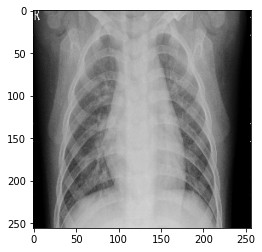

In [8]:
# 샘플 이미지 확인
image, label = next(iter(train_ds)) # (16,256,256,3)

plt.imshow(image[0])
plt.show()



In [9]:
# 모델 빌드
inputs = layers.Input(shape=(256,256,3))

# # 데이터 증강
# data_augmentation = keras.Sequential([
#     layers.RandomFlip('horizontal'),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.2),
# ])

# Block 1
# x = data_augmentation(inputs)
x = layers.Conv2D(8, (3, 3),activation='relu',padding='same',name='block1_conv1')(inputs)
x = layers.Conv2D(8, (3, 3),activation='relu',padding='same',name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(16, (3, 3),activation='relu',padding='same',name='block2_conv1')(x)
x = layers.Conv2D(16, (3, 3),activation='relu',padding='same',name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(32, (3, 3),activation='relu',padding='same',name='block3_conv1')(x)
x = layers.Conv2D(32, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
x = layers.Conv2D(32, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block4_conv1')(x)
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block4_conv2')(x)
x = layers.Conv2D(64, (3, 3),activation='relu',padding='same',name='block4_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block5_conv1')(x)
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block5_conv2')(x)
x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation='relu', name='fc1')(x)
x = layers.Dense(1024, activation='relu', name='fc2')(x)
outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='vgg16')

model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 8)       224       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 8)       584       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 8)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 16)      1168      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 16)      2320      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 16)        0     

In [32]:
# 훈련
callbacks = [
    keras.callbacks.ModelCheckpoint('vgg16.h5',save_best_only=True),
    keras.callbacks.TensorBoard(log_dir='logs')]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 30
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/30
326/326 [==============================] - 21s 58ms/step - loss: 0.1606 - accuracy: 0.9482 - val_loss: 1.4722 - val_accuracy: 0.7500
Epoch 2/30
326/326 [==============================] - 19s 57ms/step - loss: 0.1276 - accuracy: 0.9557 - val_loss: 0.4464 - val_accuracy: 0.8750
Epoch 3/30
326/326 [==============================] - 19s 57ms/step - loss: 0.1044 - accuracy: 0.9689 - val_loss: 0.3151 - val_accuracy: 0.8125
Epoch 4/30
326/326 [==============================] - 19s 57ms/step - loss: 0.0915 - accuracy: 0.9689 - val_loss: 0.2922 - val_accuracy: 0.9375
Epoch 5/30
326/326 [==============================] - 19s 57ms/step - loss: 0.0848 - accuracy: 0.9730 - val_loss: 0.7126 - val_accuracy: 0.7500
Epoch 6/30
326/326 [==============================] - 19s 57ms/step - loss: 0.0834 - accuracy: 0.9741 - val_loss: 0.2772 - val_accuracy: 0.8125
Epoch 7/30
326/326 [==============================] - 19s 56ms/step - loss: 0.0896 - accuracy: 0.9730 - val_loss: 0.6098 - val_accuracy:

In [35]:
# 평가
model = keras.models.load_model('vgg16.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f'test acc : {test_acc:.3f}, test loss : {test_loss:.3f}')

39/39 [==============================] - 2s 35ms/step - loss: 25.7644 - accuracy: 0.7404
test acc : 0.740, test loss : 25.764


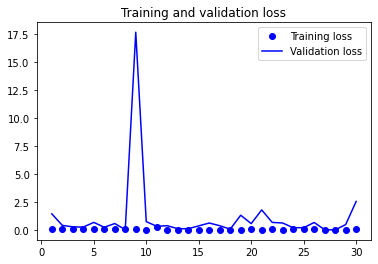

In [34]:
# 그래프
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,epochs+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
import keras_tuner as kt

#데이터 텐서로 변경
train_images = []
train_labels = []
for images, labels in train_ds:
    train_images.append(images)
    train_labels.append(labels)
train_images = tf.concat(train_images, axis=0)
train_labels = tf.concat(train_labels, axis=0)

val_images = []
val_labels = []
for images, labels in val_ds:
    val_images.append(images)
    val_labels.append(labels)
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

test_images = []
test_labels = []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)
test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)

train_images = tf.convert_to_tensor(train_images)
train_labels = tf.convert_to_tensor(train_labels)

val_images = tf.convert_to_tensor(val_images)
val_labels = tf.convert_to_tensor(val_labels)

test_images = tf.convert_to_tensor(test_images)
test_labels = tf.convert_to_tensor(test_labels)

#하이퍼파라미터 튜닝
tuner = kt.BayesianOptimization(
    model,
    objective='val_accuracy',
    max_trials=30, #모델설정 최대 횟수
    executions_per_trial=2, # 동일한 모델 테스트 횟수 > 결과 평균
    directory='mnist_kt_test', # 탐색 로그 저장할 위치
    overwrite=True # 이어서 할 경우 False , 새로 할 경우 True
)

tuner.search_space_summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
]
 
tuner.search(train_ds,
             batch_size=16,
             epochs=30,
             validation_data=val_ds,
             callbacks=callbacks,
             verbose=2)

#시간상 미진행

In [ ]:
# 텐서보드
# pip install -U tensorboard
# pip install protobuf==3.20.0
# export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

tensorboard dev upload --logdir 'logs' --name "vgg16"
